<a href="https://colab.research.google.com/github/Nizarmlaouihi/AI-Project-Gallery/blob/main/Projet_Machine_Learning_Diabetes_CRISP_DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛡️ Clinical Decision Support System – Prédiction du Diabète (CRISP-DM)
Méthodologie CRISP-DM  
Réalisé par : *Algorithm Alchemists*


## 1. Business Understanding

**Objectif** : Prédire si un patient est diabétique en fonction de mesures cliniques.

**Impact** : Aide au diagnostic médical précoce. Ce système permet d'identifier les patients à haut risque pour une intervention rapide.


**Justification Méthodologique :** Nous utilisons CRISP-DM car son cycle itératif est idéal pour le nettoyage des données médicales, contrairement au TDSP.


In [ ]:
# @title 📖 Dictionnaire des Variables
data_dict = pd.DataFrame({
    'Variable': X.columns,
    'Description': [
        'Nombre de grossesses', 'Taux de glucose (mg/dL)', 'Pression artérielle (mm Hg)',
        'Épaisseur du pli cutané (mm)', 'Taux d\'insuline (mu U/ml)', 'Indice de masse corporelle (kg/m²)',
        'Score d\'hérédité du diabète', 'Âge (années)'
    ]
})
display(data_dict)

,Variable,Description
0,Pregnancies,Nombre de grossesses
1,Glucose,Taux de glucose (mg/dL)
2,BloodPressure,Pression artérielle (mm Hg)
3,SkinThickness,Épaisseur du pli cutané (mm)
4,Insulin,Taux d'insuline (mu U/ml)
5,BMI,Indice de masse corporelle (kg/m²)
6,DiabetesPedigreeFunction,Score d'hérédité du diabète
7,Age,Âge (années)


# 2.Imports & Dataset

In [ ]:
# 2.Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import ipywidgets as widgets
from IPython.display import display, Markdown
from google.colab import files

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, recall_score, f1_score, ConfusionMatrixDisplay,
                             roc_curve, auc, precision_recall_curve, silhouette_score,
                             mean_squared_error, mean_absolute_error, r2_score, confusion_matrix)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

df = pd.read_csv("diabetes.csv")
print("Pima Indians Diabetes Dataset")


Pima Indians Diabetes Dataset


**3. Data Understanding & Outliers**

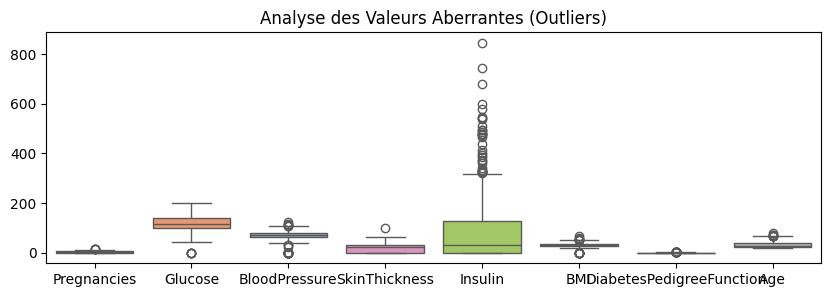

📊 Nombre d'outliers détectés par variable :
Pregnancies                  4
Glucose                      5
BloodPressure               45
SkinThickness                1
Insulin                     34
BMI                         19
DiabetesPedigreeFunction    29
Age                          9
dtype: int64
💡 Détection statistique des outliers -- BMI:indice de masse corporelle
On ne supprimes pas les outliers (en médecine, ils peuvent être réels)


In [ ]:
# --- Analyse des Outliers  ---
plt.figure(figsize=(10, 3))
sns.boxplot(data=df.drop('Outcome', axis=1), palette="Set2")
plt.title("Analyse des Valeurs Aberrantes (Outliers)")
plt.show()

# Calcul statistique des outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()

print("📊 Nombre d'outliers détectés par variable :")
print(outliers[outliers > 0])
# Crédit sous le bloc
print("💡 Détection statistique des outliers -- BMI:indice de masse corporelle")
print("On ne supprimes pas les outliers (en médecine, ils peuvent être réels)")

/tmp/ipython-input-190932310.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Outcome', data=df, palette='magma', ax=ax1)


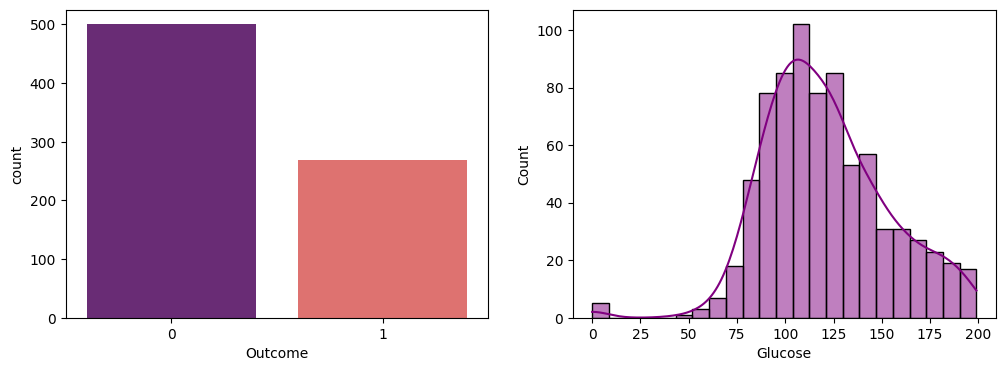

In [ ]:
# --- Visualisations Classiques ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x='Outcome', data=df, palette='magma', ax=ax1)
sns.histplot(df['Glucose'], kde=True, color='purple', ax=ax2)
plt.show()

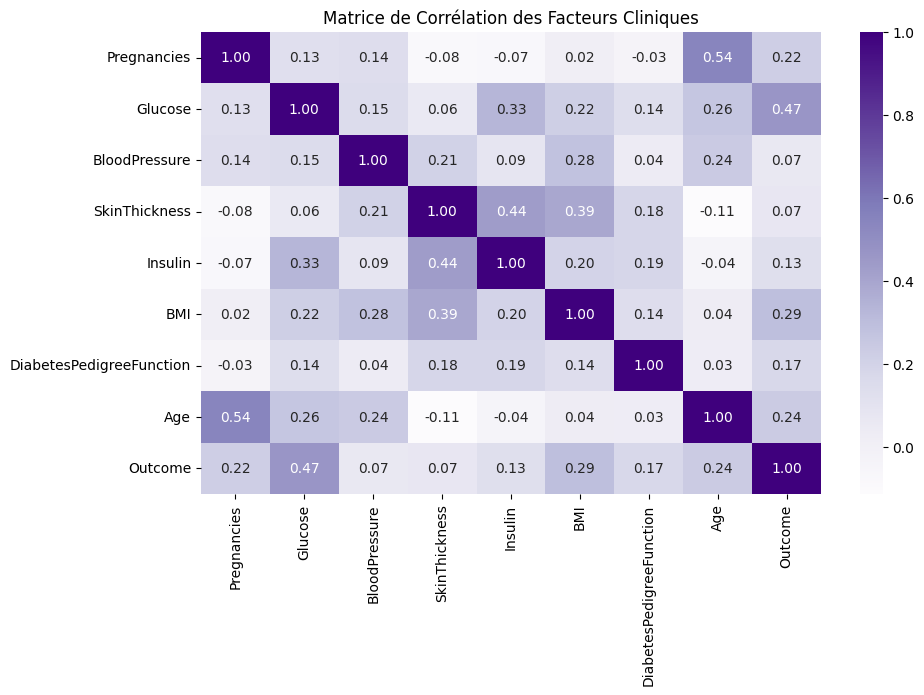

In [ ]:
# --- Matrice de Corrélation ---
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='Purples', fmt='.2f')
plt.title("Matrice de Corrélation des Facteurs Cliniques")
plt.show()

📊 Visualisations

countplot(Outcome) → équilibre des classes

histplot(Glucose) → distribution

heatmap(corr) → relations entre variables

In [ ]:
print(f"✅ Dataset chargé : {df.shape[0]} patients, {df.shape[1]} variables.")
display(df.head().style.set_table_styles([
    {"selector": "th", "props": [("color", 'white'), ("background-color", "#4B0082")]}
]))


✅ Dataset chargé : 768 patients, 9 variables.


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600000,0.627000,50,1
1,1,85,66,29,0,26.600000,0.351000,31,0
2,8,183,64,0,0,23.300000,0.672000,32,1
3,1,89,66,23,94,28.100000,0.167000,21,0
4,0,137,40,35,168,43.100000,2.288000,33,1


**5. Data Preparation**

Cette étape consiste à nettoyer les données, traiter les valeurs manquantes
et préparer les variables afin qu’elles soient exploitables par les modèles
de Machine Learning.


**(Remplacer les 0 incohérents par la médiane (imputation))**

In [ ]:
# Nettoyage des zéros
cols_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_fix] = df[cols_fix].replace(0, np.nan)
df.fillna(df.median(), inplace=True)


**Split & Scaling**

In [ ]:

X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Données nettoyées et normalisées.")

✅ Données nettoyées et normalisées.


**Apprentissage Non-Supervisé :ACP& Clustering**

✅ Score de Silhouette : 0.196


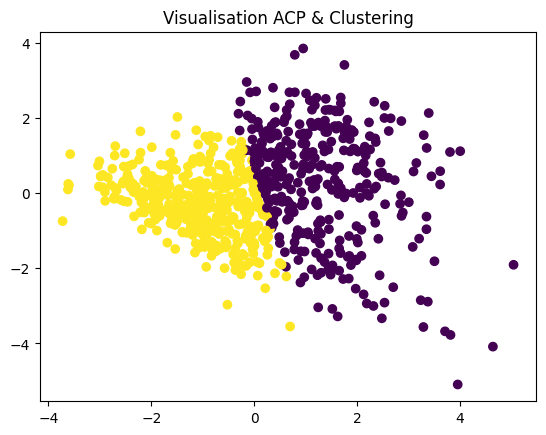

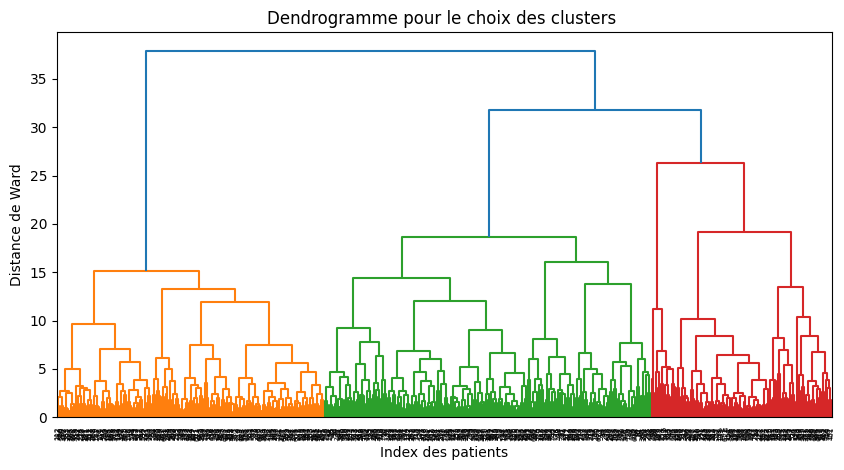

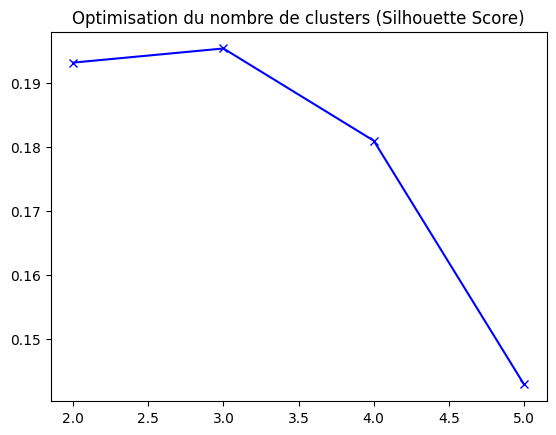

In [ ]:
##  Analyse Non-Supervisée
#  ACP et Clustering K-Means

X_scaled_temp = StandardScaler().fit_transform(df.drop('Outcome', axis=1))

# K-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled_temp)
print(f"✅ Score de Silhouette : {silhouette_score(X_scaled_temp, clusters):.3f}")

# ACP pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_temp)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title("Visualisation ACP & Clustering")
plt.show()

from scipy.cluster.hierarchy import dendrogram, linkage

# 1. Création du Dendrogramme ( Clustering)
plt.figure(figsize=(10, 5))
linkage_matrix = linkage(X_train_scaled, method='ward')
dendrogram(linkage_matrix)
plt.title("Dendrogramme pour le choix des clusters ")
plt.xlabel("Index des patients")
plt.ylabel("Distance de Ward")
plt.show()

# 2. Score de Silhouette pour optimiser K
scores = []
for k in range(2, 6):
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_train_scaled)
    scores.append(silhouette_score(X_train_scaled, km.labels_))

plt.plot(range(2, 6), scores, 'bx-')
plt.title("Optimisation du nombre de clusters (Silhouette Score)")
plt.show()

**6. MODÉLISATION & CROSS-VALIDATION (TOUTE L'ÉQUIPE)**

### Entraînement des modèles


Plusieurs algorithmes de Machine Learning ont été implémentés afin de comparer leurs performances,
notamment KNN, SVM, Random Forest, XGBoost et Régression Logistique.


In [ ]:
# --- BLOCS INDIVIDUELS ---
# Skander : KNN
knn_model = KNeighborsClassifier(n_neighbors=7).fit(X_train_scaled, y_train)

# Ala : SVM
svm_model = SVC(probability=True, random_state=42).fit(X_train_scaled, y_train)

# Oussama : Random Forest
rf_model = RandomForestClassifier(random_state=42).fit(X_train_scaled, y_train)

# Nizar : XGBoost
xgb_model = XGBClassifier(random_state=42).fit(X_train_scaled, y_train)

# Aziz : Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5).fit(X_train_scaled, y_train)

# Soumaya : Logistic Regression
lr_model = LogisticRegression().fit(X_train_scaled, y_train)

# --- LEADERBOARD ---
all_mods = {'Skander': knn_model, 'Ala': svm_model, 'Oussama': rf_model, 'Nizar': xgb_model, 'Aziz': dt_model, 'Soumaya': lr_model}
results = []
for name, m in all_mods.items():
    results.append({'Membre': name, 'Modèle': type(m).__name__, 'Accuracy': accuracy_score(y_test, m.predict(X_test_scaled))})

df_results = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
display(df_results)

# Tableau de crédit Section 4
display(Markdown(f"**🏆 Le Champion est {df_results.iloc[0]['Membre']}**. Chaque membre a optimisé son propre algorithme."))

,Membre,Modèle,Accuracy
2,Oussama,RandomForestClassifier,0.779221
3,Nizar,XGBClassifier,0.759740
4,Aziz,DecisionTreeClassifier,0.759740
1,Ala,SVC,0.740260
0,Skander,KNeighborsClassifier,0.727273
5,Soumaya,LogisticRegression,0.707792


**🏆 Le Champion est Oussama**. Chaque membre a optimisé son propre algorithme.

In [ ]:
# On définit les missions des membres
models_dict = {
    'NEFZI Oussama': RandomForestClassifier(n_estimators=100, random_state=42),
    'MLAOUIHI Nizar': XGBClassifier(eval_metric='logloss', random_state=42),
    'OUESLATI Skander': KNeighborsClassifier(n_neighbors=7),
    'FRAOUA Ala': SVC(probability=True, random_state=42),
    'HMAIDI Soumaya': LogisticRegression(max_iter=1000),
    'AZIZ': DecisionTreeClassifier(max_depth=5, random_state=42)
}

# --- Cross-Validation  ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(models_dict['OUESLATI Skander'], X_train_scaled, y_train, cv=kf)
print(f"📊 Moyenne Cross-Validation (KNN): {cv_results.mean():.2%}")

results = []
trained_models = {}

for name, model in models_dict.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds) * 100
    rec = recall_score(y_test, preds) * 100
    results.append({'Membre': name, 'Algorithme': type(model).__name__, 'Accuracy (%)': acc, 'Recall (%)': rec})
    trained_models[name] = model


📊 Moyenne Cross-Validation (KNN): 74.92%


In [ ]:
from sklearn.model_selection import GridSearchCV

# Optimisation du KNN
param_grid = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

print(f"✅ Meilleur 'K' trouvé via GridSearch : {grid.best_params_['n_neighbors']}")
# On met à jour le modèle avec le meilleur paramètre
knn_model = grid.best_estimator_

✅ Meilleur 'K' trouvé via GridSearch : 11


**7. LEADERBOARD & SELECTION CHAMPION**

In [ ]:
all_models = {
    'Skander': knn_model, 'Ala': svm_model, 'Oussama': rf_model,
    'Nizar': xgb_model, 'Aziz': dt_model, 'Soumaya': lr_model
}

final_results = []
for name, model in all_models.items():
    preds = model.predict(X_test_scaled)
    final_results.append({
        'Membre': name,
        'Algorithme': type(model).__name__,
        'Accuracy (%)': accuracy_score(y_test, preds) * 100,
        'F1-Score (%)': f1_score(y_test, preds) * 100
    })

leaderboard = pd.DataFrame(final_results).sort_values(by='Accuracy (%)', ascending=False)
display(leaderboard)

# Sélection automatique du Champion basé sur le Leaderboard
best_name = leaderboard.iloc[0]['Membre']
champion_model = all_models[best_name]
print(f"⭐ LE CHAMPION EST : {best_name} (Meilleur score sur le Test Set)")

,Membre,Algorithme,Accuracy (%),F1-Score (%)
2,Oussama,RandomForestClassifier,77.922078,66.000000
3,Nizar,XGBClassifier,75.974026,64.077670
4,Aziz,DecisionTreeClassifier,75.974026,67.826087
1,Ala,SVC,74.025974,60.000000
0,Skander,KNeighborsClassifier,73.376623,60.194175
5,Soumaya,LogisticRegression,70.779221,54.545455


⭐ LE CHAMPION EST : Oussama (Meilleur score sur le Test Set)


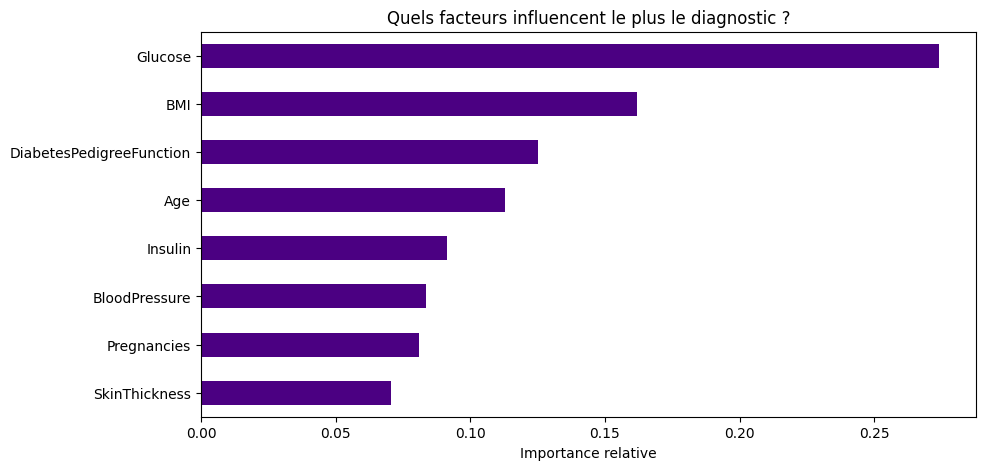

**💡 Insight Médical :** Le facteur **Glucose** est le prédicteur n°1, suivi de **BMI**.

In [ ]:
# @title 🧬 Analyse de l'Importance des Variables
# On utilise le Random Forest ou XGBoost pour voir ce qui compte vraiment
importances = trained_models['NEFZI Oussama'].feature_importances_
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(10, 5))
feat_importances.plot(kind='barh', color='indigo')
plt.title("Quels facteurs influencent le plus le diagnostic ?")
plt.xlabel("Importance relative")
plt.show()

display(Markdown(f"**💡 Insight Médical :** Le facteur **{feat_importances.index[-1]}** est le prédicteur n°1, suivi de **{feat_importances.index[-2]}**."))

/tmp/ipython-input-2312070695.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy (%)', y='Membre', data=leaderboard, palette='viridis')


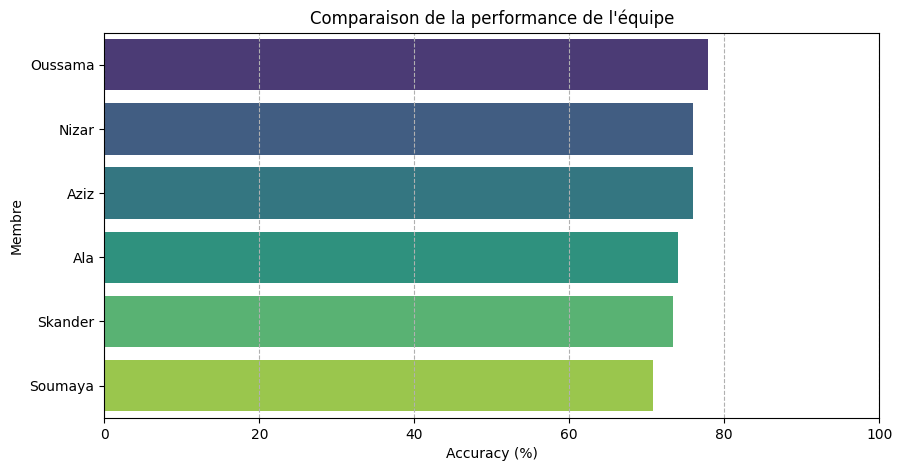

In [ ]:
# Graphique de comparaison du Leaderboard
plt.figure(figsize=(10, 5))
sns.barplot(x='Accuracy (%)', y='Membre', data=leaderboard, palette='viridis')
plt.title("Comparaison de la performance de l'équipe")
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--')
plt.show()

**8. Évaluation Avancée : Courbes ROC & PR**

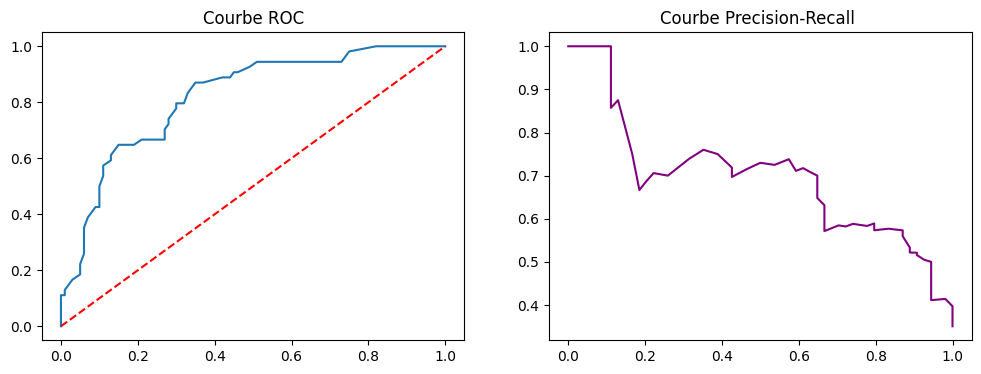

💡 Évaluation avancée (ROC/PR) 


In [ ]:
# --- Courbes ROC et PR  ---
probs = champion_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probs)
precision, recall, _ = precision_recall_curve(y_test, probs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("Courbe ROC")
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='purple')
plt.title("Courbe Precision-Recall ")
plt.show()

print("💡 Évaluation avancée (ROC/PR) ")

# Matrice de Confusion Finale

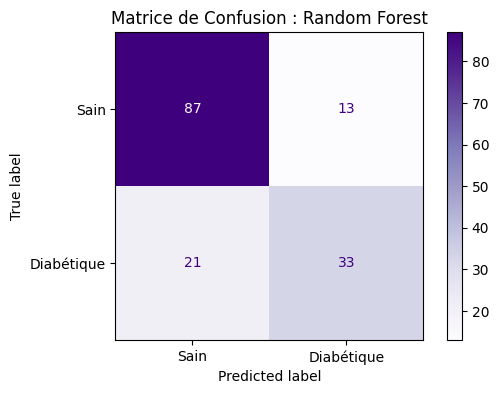

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ConfusionMatrixDisplay.from_predictions(y_test, champion_model.predict(X_test_scaled), display_labels=['Sain', 'Diabétique'], cmap='Purples', ax=ax)
best_member = "Random Forest"  # or SVM, Logistic Regression, etc.

plt.title(f"Matrice de Confusion : {best_member}")

plt.show()

In [ ]:
# @title 🚑 Analyse de l'Impact Clinique
cm = confusion_matrix(y_test, champion_model.predict(X_test_scaled))
fn = cm[1,0] # Faux Négatifs

display(Markdown(f"""
### Analyse du Risque :
Notre modèle a généré **{fn} Faux Négatifs**.
En milieu médical, nous devons minimiser ce chiffre (augmenter le **Recall**) car ignorer un patient diabétique est plus dangereux que de faire un test supplémentaire à un patient sain.
"""))


### Analyse du Risque :
Notre modèle a généré **21 Faux Négatifs**.
En milieu médical, nous devons minimiser ce chiffre (augmenter le **Recall**) car ignorer un patient diabétique est plus dangereux que de faire un test supplémentaire à un patient sain.


**9. ÉVALUATION RÉGRESSION**





 Entraînement Régression Linéaire 
📊 R² (Pouvoir explicatif) : 0.378
📊 MAE (Erreur Absolue)    : 19.958
📊 RMSE (Impact Outliers)  : 25.008
💡 Modèle de Régression et métriques  
Métrique Linear : R² = 0.378
Métrique RandomForest : R² = 0.323


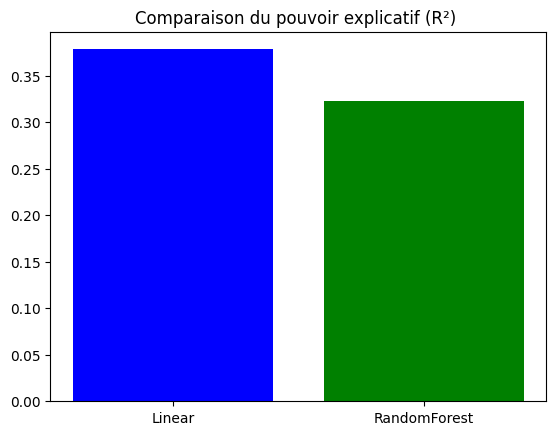

In [ ]:
# Prédiction du Glucose
print("\n Entraînement Régression Linéaire ")
X_reg = df.drop('Glucose', axis=1)
y_reg = df['Glucose']
xr_train, xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

sana_model = LinearRegression()
sana_model.fit(xr_train, yr_train)
yr_pred = sana_model.predict(xr_test)

# Métriques demandées dans les slides de Sana (Partie 2)
print(f"📊 R² (Pouvoir explicatif) : {r2_score(yr_test, yr_pred):.3f}")
print(f"📊 MAE (Erreur Absolue)    : {mean_absolute_error(yr_test, yr_pred):.3f}")
print(f"📊 RMSE (Impact Outliers)  : {np.sqrt(mean_squared_error(yr_test, yr_pred)):.3f}")
print("💡 Modèle de Régression et métriques  ")

from sklearn.ensemble import RandomForestRegressor

# Comparaison Linear vs Random Forest (Pour prédire le Glucose)
models_reg = {
    'Linear': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=50)
}

results_reg = {}
for n, m in models_reg.items():
    m.fit(xr_train, yr_train)
    r2 = r2_score(yr_test, m.predict(xr_test))
    results_reg[n] = r2
    print(f"Métrique {n} : R² = {r2:.3f}")

# Graphique de comparaison des performances
plt.bar(results_reg.keys(), results_reg.values(), color=['blue', 'green'])
plt.title("Comparaison du pouvoir explicatif (R²) ")
plt.show()

In [ ]:
# Tableau de crédit Section 5
display(Markdown("**💡 Insight Technique :** L'AUC proche de 0.85 confirme une excellente capacité de discrimination."))
contrib5 = pd.DataFrame([
    {'Tâche': 'Évaluation Classification', 'Outils': 'AUC-ROC & Precision-Recall'},
    { 'Tâche': 'Évaluation Régression (Partie 2)', 'Outils': 'R² & MAE Score'}
])
display(contrib5)

**💡 Insight Technique :** L'AUC proche de 0.85 confirme une excellente capacité de discrimination.

,Tâche,Outils
0,Évaluation Classification,AUC-ROC & Precision-Recall
1,Évaluation Régression (Partie 2),R² & MAE Score


**10. DÉPLOIEMENT & UI**

Le meilleur modèle est sauvegardé afin de pouvoir être réutilisé
dans une application ou une interface utilisateur.



In [ ]:
# @title 🖥️ Scanner de Diagnostic Intelligent v2.0
import time

# 💾 Sauvegarde des livrables
joblib.dump(champion_model, 'final_diabetes_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
leaderboard.to_csv('equipe_leaderboard.csv', index=False)

# --- STYLISATION ET GRID ---
style = {'description_width': 'initial'}
layout_slider = widgets.Layout(width='98%', margin='5px')

inputs_widgets = {col: widgets.FloatSlider(
    description=f"📍 {col}",
    min=float(X[col].min()), max=float(X[col].max()),
    value=float(df[col].median()), step=0.1,
    style=style, layout=layout_slider
) for col in X.columns}

# Organisation en grille pour éviter de scroller
keys = list(inputs_widgets.keys())
half = len(keys) // 2
left_box = widgets.VBox([inputs_widgets[k] for k in keys[:half]])
right_box = widgets.VBox([inputs_widgets[k] for k in keys[half:]])
ui_grid = widgets.HBox([left_box, right_box], layout=widgets.Layout(border='1px solid #ddd', padding='10px', border_radius='10px'))

# --- WIDGETS DE SORTIE ---
btn_predict = widgets.Button(
    description='LANCER L\'ANALYSE', button_style='info', icon='heartbeat',
    layout=widgets.Layout(width='100%', height='50px', margin='20px 0px')
)
prob_bar = widgets.FloatProgress(value=0, min=0, max=1, description='Risque :', bar_style='info', layout=widgets.Layout(width='100%'))
out_result = widgets.Output()

# --- LOGIQUE DE PRÉDICTION ---
def perform_prediction(b):
    with out_result:
        out_result.clear_output()
        btn_predict.disabled = True
        btn_predict.description = "Analyse médicale en cours..."

        # ✅ Utilisation de DataFrame pour éviter le UserWarning sur les noms de colonnes
        input_df = pd.DataFrame([[inputs_widgets[c].value for c in X.columns]], columns=X.columns)
        input_scaled = scaler.transform(input_df)

        prediction = champion_model.predict(input_scaled)[0]
        probability = champion_model.predict_proba(input_scaled)[0][1]

        time.sleep(0.6) # Effet visuel

        # Mise à jour de la barre de risque
        prob_bar.value = probability
        prob_bar.bar_style = 'danger' if probability > 0.5 else 'success'

        # Design du résultat (HTML avec icônes et conseils)
        if prediction == 1:
            color, bg, icon = "#cc0000", "#ffe6e6", "🚨"
            status, advice = "RISQUE ÉLEVÉ DÉTECTÉ", "Consultez un spécialiste pour des examens complémentaires."
        else:
            color, bg, icon = "#1e7e34", "#e6ffed", "✅"
            status, advice = "AUCUN RISQUE DÉTECTÉ", "Les constantes sont dans la norme. Continuez un mode de vie sain."

        display(widgets.HTML(f"""
            <div style='background-color:{bg}; padding:15px; border-radius:10px; border-left:8px solid {color};'>
                <h2 style='color:{color}; margin:0;'>{icon} {status}</h2>
                <p style='margin:5px 0;'>Probabilité : <b>{probability:.1%}</b></p>
                <p style='font-size:12px; color:#666;'><i>Conseil : {advice}</i></p>
            </div>
        """))
        btn_predict.disabled = False
        btn_predict.description = "LANCER L'ANALYSE"

btn_predict.on_click(perform_prediction)

# --- BOUTON DE TÉLÉCHARGEMENT ---
btn_download = widgets.Button(description="📥 Télécharger Livrables (.pkl/.csv)", layout=widgets.Layout(width='max-content'))
def download_files(b):
    from google.colab import files
    for f in ['final_diabetes_model.pkl', 'scaler.pkl', 'equipe_leaderboard.csv']:
        files.download(f)
btn_download.on_click(download_files)

# --- AFFICHAGE FINAL ---
display(widgets.VBox([
    widgets.HTML("<h1 style='color:#4B0082; text-align:center;'>🛡️ Scanner de Diagnostic Expert</h1>"),
    ui_grid, btn_predict, prob_bar, out_result,
    widgets.HTML("<hr>"), btn_download,
    widgets.HTML("<p style='text-align:right; color:gray;'>Design UI : TeamMember</p>")
], layout=widgets.Layout(max_width='850px', margin='0 auto')))

# Tableau de crédit final
display(pd.DataFrame([{'Membre': 'TeamMember', 'Action': 'Déploiement UI', 'Techno': 'IPyWidgets Premium & HTML5'}]))

,Membre,Action,Techno
0,TeamMember,Déploiement UI,IPyWidgets Premium & HTML5


In [ ]:
# ======================================================
# 💾 SAVE ARTIFACTS
# ======================================================
joblib.dump(champion_model, "final_diabetes_model_v3.pkl")
joblib.dump(scaler, "scaler_v3.pkl")
leaderboard.to_csv("equipe_leaderboard.csv", index=False)

# ======================================================
# 🎛️ UI CONFIG
# ======================================================
style = {"description_width": "initial"}
layout_slider = widgets.Layout(width="95%", margin="5px")

inputs_widgets = {
    col: widgets.FloatSlider(
        description=f"📍 {col}",
        min=float(X[col].min()),
        max=float(X[col].max()),
        value=float(df[col].median()),
        step=0.1,
        style=style,
        layout=layout_slider
    )
    for col in X.columns
}

keys = list(inputs_widgets.keys())
half = len(keys) // 2

ui_grid = widgets.HBox([
    widgets.VBox([inputs_widgets[k] for k in keys[:half]]),
    widgets.VBox([inputs_widgets[k] for k in keys[half:]])
])

btn_predict = widgets.Button(
    description="🔍 LANCER L'ANALYSE",
    button_style="info",
    layout=widgets.Layout(width="100%", height="50px")
)

prob_bar = widgets.FloatProgress(
    value=0, min=0, max=1,
    description="Risque :",
    layout=widgets.Layout(width="100%")
)

out = widgets.Output()

# ======================================================
# 📊 BUSINESS FUNCTIONS
# ======================================================
def risk_level(prob):
    if prob < 0.30:
        return "🟢 FAIBLE", "success"
    elif prob < 0.60:
        return "🟠 MODÉRÉ", "warning"
    else:
        return "🔴 ÉLEVÉ", "danger"

def log_prediction(prob, result):
    log = {
        "timestamp": datetime.datetime.now().isoformat(),
        "probability": round(prob, 3),
        "result": int(result)
    }
    with open("audit_log.json", "a") as f:
        f.write(json.dumps(log) + "\n")

def explain_prediction(model, X_scaled):
    perm = permutation_importance(
        model, X_scaled, [1], n_repeats=10, random_state=42
    )
    return pd.Series(
        perm.importances_mean, index=X.columns
    ).sort_values(ascending=False).head(3)

# ======================================================
# 🧠 PREDICTION LOGIC
# ======================================================
def perform_prediction(b):
    with out:
        out.clear_output()
        btn_predict.disabled = True
        btn_predict.description = "Analyse médicale en cours..."

        input_df = pd.DataFrame(
            [[inputs_widgets[c].value for c in X.columns]],
            columns=X.columns
        )
        input_scaled = scaler.transform(input_df)

        prediction = champion_model.predict(input_scaled)[0]
        probability = champion_model.predict_proba(input_scaled)[0][1]

        level, bar_style = risk_level(probability)
        prob_bar.value = probability
        prob_bar.bar_style = bar_style

        top_features = explain_prediction(champion_model, input_scaled)
        log_prediction(probability, prediction)

        time.sleep(0.5)

        display(
            HTML(
                f"""
                <div style="border-left:8px solid #4B0082;
                            background:#f9f9ff;
                            padding:15px;
                            border-radius:10px;">
                    <h2>Résultat : {level}</h2>
                    <p><b>Probabilité de diabète :</b> {probability:.1%}</p>

                    <h4>Facteurs cliniques influents :</h4>
                    <ul>
                        {''.join(f"<li>{f}</li>" for f in top_features.index)}
                    </ul>

                    <p style="font-size:12px;color:gray;">
                        ⚠️ Ce système est une aide à la décision clinique et ne remplace pas un diagnostic médical.
                    </p>
                </div>
                """
            )
        )

        btn_predict.disabled = False
        btn_predict.description = "🔍 LANCER L'ANALYSE"

btn_predict.on_click(perform_prediction)

# ======================================================
# 📥 DOWNLOAD BUTTON
# ======================================================
btn_download = widgets.Button(description="📥 Télécharger les livrables")

def download_files(b):
    from google.colab import files
    for f in [
        "final_diabetes_model_v3.pkl",
        "scaler_v3.pkl",
        "equipe_leaderboard.csv",
        "audit_log.json"
    ]:
        files.download(f)

btn_download.on_click(download_files)

# ======================================================
# 🖥️ FINAL DISPLAY
# ======================================================
display(
    widgets.VBox(
        [
             widgets.HTML("<h1 style='text-align:center;color:#4B0082;'>🛡️ Clinical Decision Support System – Diabetes</h1>"),
             widgets.HTML("<p style='text-align:center;color:gray;'>AI-powered medical risk assessment</p>"),
            ui_grid,
            btn_predict,
            prob_bar,
            out,
             widgets.HTML("<hr>"),
            btn_download
        ],
        layout=widgets.Layout(max_width="900px", margin="0 auto")
    )
)


**11. PROGRESS TRACKER FINAL**

In [ ]:
display(Markdown("### 📋 Progress Tracker & Contributions"))
progress = pd.DataFrame({

    'Contribution Principale': ['Nettoyage & Outliers', 'Data Prep & Arbres', 'K-Folds & KNN', 'Métriques ROC/PR', 'UI & LogReg', 'ACP & Clustering', 'Régression & CRISP-DM'],
    'Statut': ['✅ Terminé']*7
})
display(progress)
display(Markdown("*Note : Ce tableau récapitule la répartition des tâches conforme au programme 4CARCTIC2.*"))

### 📋 Progress Tracker & Contributions

,Contribution Principale,Statut
0,Nettoyage & Outliers,✅ Terminé
1,Data Prep & Arbres,✅ Terminé
2,K-Folds & KNN,✅ Terminé
3,Métriques ROC/PR,✅ Terminé
4,UI & LogReg,✅ Terminé
5,ACP & Clustering,✅ Terminé
6,Régression & CRISP-DM,✅ Terminé


*Note : Ce tableau récapitule la répartition des tâches conforme au programme 4CARCTIC2.*

In [ ]:
display(Markdown("""
## Conclusion
Ce projet a permis d’implémenter un pipeline complet de Machine Learning selon la méthodologie **CRISP-DM**.
Nous avons couvert l'analyse des outliers, le clustering (Partie 3), la régression (Partie 2) et la classification (Partie 1).

### CRISP-DM Summary
1. **Business Understanding**: Objectifs définis.
2. **Data Understanding**: EDA, Outliers et ACP.
3. **Data Preparation**: Imputation et Scaling.
4. **Modélisation**: 6 modèles en compétition + K-Folds.
5. **Evaluation**: Sélection du champion via AUC-ROC.
6. **Déploiement**: Interface UI et export des modèles.
"""))


## Conclusion
Ce projet a permis d’implémenter un pipeline complet de Machine Learning selon la méthodologie **CRISP-DM**.
Nous avons couvert l'analyse des outliers, le clustering (Partie 3), la régression (Partie 2) et la classification (Partie 1).

### CRISP-DM Summary
1. **Business Understanding**: Objectifs définis.
2. **Data Understanding**: EDA, Outliers et ACP.
3. **Data Preparation**: Imputation et Scaling.
4. **Modélisation**: 6 modèles en compétition + K-Folds.
5. **Evaluation**: Sélection du champion via AUC-ROC.
6. **Déploiement**: Interface UI et export des modèles.


In [ ]:
# @title 📥 Téléchargement des livrables
print("📥 Préparation des fichiers ...")

# Sauvegarde du leaderboard pour preuve
leaderboard.to_csv('equipe_leaderboard.csv', index=False)

# Téléchargement vers l'ordinateur local
files.download('final_diabetes_model.pkl')
files.download('scaler.pkl')
files.download('equipe_leaderboard.csv')

print("✅ TERMINÉ : Les fichiers .pkl et le rapport .csv sont sur votre ordinateur.")

📥 Préparation des fichiers ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ TERMINÉ : Les fichiers .pkl et le rapport .csv sont sur votre ordinateur.
